In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals

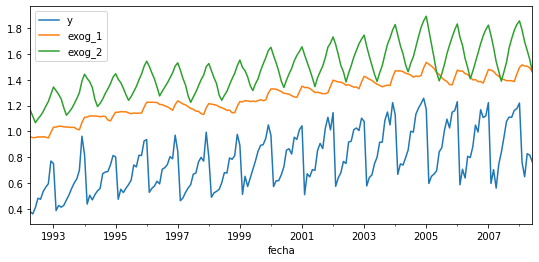

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

## ForecasterAutoreg

In [4]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.09603586]


,pred
1999-07-01,0.684784
1999-08-01,0.673355
1999-09-01,0.672449
1999-10-01,0.660822
1999-11-01,0.651780
...,...
2008-02-01,0.655673
2008-03-01,0.655675
2008-04-01,0.655675
2008-05-01,0.655674


In [12]:
residuals = predictions_backtest['pred'] - data_test['y']
residuals

1999-07-01   -0.085864
1999-08-01   -0.172831
1999-09-01   -0.220280
1999-10-01   -0.237077
1999-11-01   -0.295500
                ...   
2008-02-01   -0.106149
2008-03-01    0.006240
2008-04-01   -0.172212
2008-05-01   -0.160581
2008-06-01   -0.106464
Freq: MS, Length: 108, dtype: float64

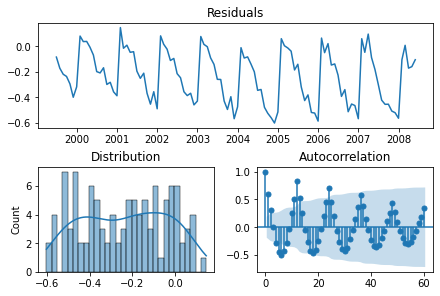

In [17]:
plot_residuals(residuals=residuals)

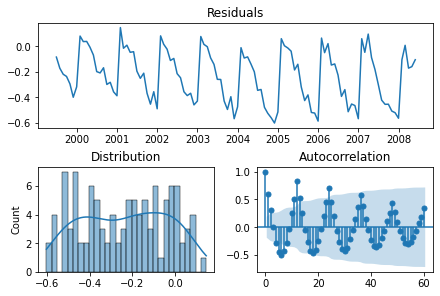

In [18]:
plot_residuals(y_true=data_test['y'], y_pred=predictions_backtest['pred'])